In [1]:
import numpy as np
import math
import gym
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.get_logger().setLevel('INFO')
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

from ddpg import DDPG
from erl import ERL

In [2]:
env = 'InvertedPendulum-v2'
# alg = 'ERL'
alg = 'DDPG'
name = 'test'

try:
    actor  = tf.keras.models.load_model(f'models/{env}-{alg}-{name}-actor')
    critic = tf.keras.models.load_model(f'models/{env}-{alg}-{name}-critic')
    print('Models loaded from disk')

except OSError:
    actor = Sequential([
        Input(4),
        Dense(12, activation='relu'),
        Dense(1, activation='tanh'),
        Lambda(lambda x: 3*x)
    ])
    critic = Sequential([
        Input(5),
        Dense(12, activation='relu'),
        Dense(1)
    ])
    print('Fresh models created')

Models loaded from disk


In [7]:
adam = Adam()
# x = epoch/epochs \in [0, 1]
action_noise = lambda x: 10**(-2*x-1) # from 0.1 to 0.001 logarythmically
ddpg = DDPG(env, actor, critic, adam, name = name, actions_per_epoch=4, training_steps_per_epoch=4,
    action_noise = action_noise)

Buffer loaded from disk


In [8]:
try:
    stats = ddpg.train(epochs = 4000, batch_size=256)

except (KeyboardInterrupt, SystemExit) as e:
    print('Interrupted')
    stats = ddpg.stats
    
ddpg.buffer.save_to_file()
actor.save( f'models/{env}-{alg}-{name}-actor')
critic.save(f'models/{env}-{alg}-{name}-critic')
ddpg.env.close()

100%|██████████| 4000/4000 [19:41<00:00,  3.39it/s, test_fitness=64.2]
INFO:tensorflow:Assets written to: models/InvertedPendulum-v2-DDPG-test-actor/assets
INFO:tensorflow:Assets written to: models/InvertedPendulum-v2-DDPG-test-critic/assets


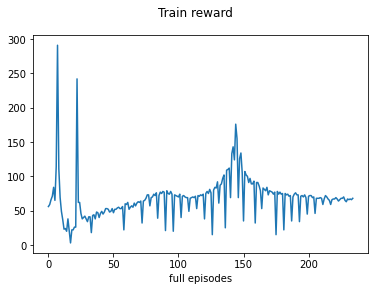

In [9]:
plt.plot(stats['reward'])
plt.suptitle('Train reward')
plt.xlabel('full episodes')
plt.savefig('imgs/train_reward_lognoise_1.jpg')

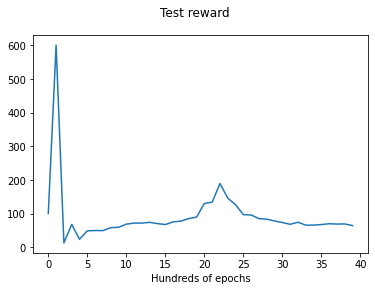

In [10]:
plt.plot(stats['test_reward'])
plt.suptitle('Test reward')
plt.xlabel('Hundreds of epochs')
plt.savefig('imgs/test_reward_lognoise_1.jpg')